In [ ]:
# https://www.mediafire.com/file/6rj25e6s79vhz16/ln_covers.zip/file
# use the link above, right click the download button and copy link address then paste it after wget

!wget #link goes here

--2024-05-13 05:57:18--  https://download948.mediafire.com/utf2hxij7ygg9XVLXLP28RudMbCVBPEDJE7lOPTes-LtEbZt8Ow3g5GIIHxZe3hcAOaupQQya0Sq3xgsiD7hMc_jPouZD2WrKbuaJRoEXyGKD8ECCoNltZYtLbpzwrg9IcuqEVQiM5X3YmSjSAfMCeb5Q97VSvyFKaDfWxXxauz1sQc5hA/6rj25e6s79vhz16/ln_covers.zip
Resolving download948.mediafire.com (download948.mediafire.com)... 205.196.121.143
Connecting to download948.mediafire.com (download948.mediafire.com)|205.196.121.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433380404 (413M) [application/zip]
Saving to: ‘ln_covers.zip’

ln_covers.zip       100%[===================>] 413.30M  36.2MB/s    in 12s     

2024-05-13 05:57:30 (34.6 MB/s) - ‘ln_covers.zip’ saved [433380404/433380404]



In [ ]:
!unzip ln_covers.zip

Archive:  ln_covers.zip
replace images/000-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
from random import randint
from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm

In [ ]:
class ImageUpscaleDataset(Dataset):
    def __init__(self, data_dir, crop_size=(128, 128)):
        self.data_dir = data_dir
        self.crop_size = crop_size
        self.image_files = os.listdir(data_dir)
        self.randomCrop = transforms.RandomResizedCrop(size=crop_size)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        cropped = self.randomCrop(img)

        lr_64 = cropped.resize((64, 64), resample=Image.BILINEAR)
        lr_128 = lr_64.resize((128, 128), resample=Image.BICUBIC)

        return self.to_tensor(lr_128), self.to_tensor(cropped), img_path

In [ ]:
class ImageUpscaler(nn.Module):
    def __init__(self):
        super(ImageUpscaler, self).__init__()
        self.feature_extractor = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.non_linear_mapping = nn.Conv2d(64, 64, kernel_size=1)
        self.reconstruction = nn.Conv2d(64, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = torch.relu(self.feature_extractor(x))
        x = torch.relu(self.non_linear_mapping(x))
        x = torch.relu(self.reconstruction(x))
        return x

In [ ]:
# load dataset
data_dir = 'images'
dataset = ImageUpscaleDataset(data_dir)
!mkdir models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []
hyperparameters = [
    {'epochs': 250, 'batch_size': 100, 'learning_rate': 0.001},
]
#     {'epochs': 5, 'batch_size': 200, 'learning_rate': 0.001},
#     {'epochs': 10, 'batch_size': 500, 'learning_rate': 0.01},
# ]

# split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = 0
test_loader = 0

for params in hyperparameters:
    # set hyperparameters
    num_epochs = params['epochs']
    batch_size_var = params['batch_size']
    learning_rate = params['learning_rate']

    # create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size_var, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_var, shuffle=False)

    model = ImageUpscaler().to(device)

    # define loss and init optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # init tqdm to track progress
        epoch_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')

        for batch_idx, (lr_images, target, _) in enumerate(epoch_loader):
            lr_images, target = lr_images.to(device), target.to(device)

            # compute prediciton and loss
            pred = model(lr_images)
            loss = loss_fn(pred, target)

            # backpropagate
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # update tqdm progress bar
            epoch_loader.set_postfix(loss=loss.item())

        if (epoch + 1) % 5 == 0:
            # save the model every 5 epochs
            now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            model_name = f"model_{now}_epochs_{epoch+1}_batch_{batch_size_var}_lr_{learning_rate}.pt"
            torch.save(model.state_dict(), os.path.join("models", model_name))



Epoch 250/250: 100%|██████████| 30/30 [00:39<00:00,  1.33s/batch, loss=0.00238]


In [ ]:
# load the model, if you have one

model_path = ""  # update with your model's path
model = ImageUpscaler()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) # loads on CPU because ran out of GPU

model.eval()

ImageUpscaler(
  (feature_extractor): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (non_linear_mapping): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (reconstruction): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

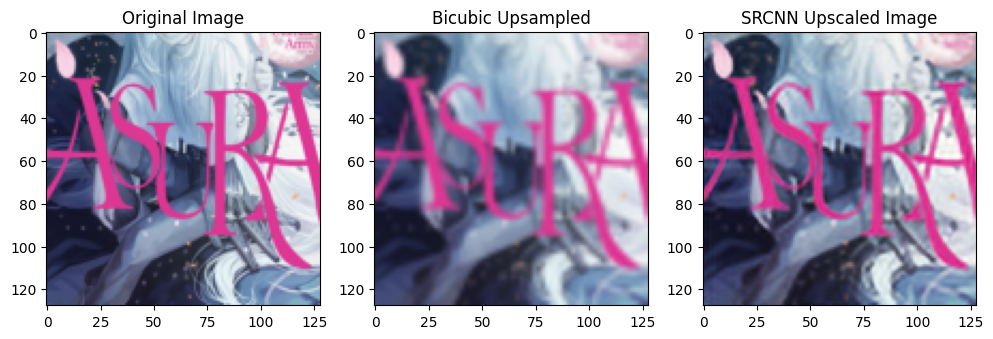

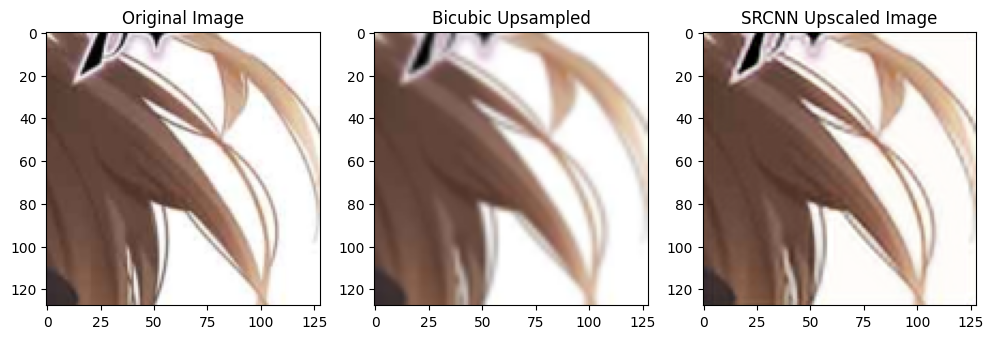

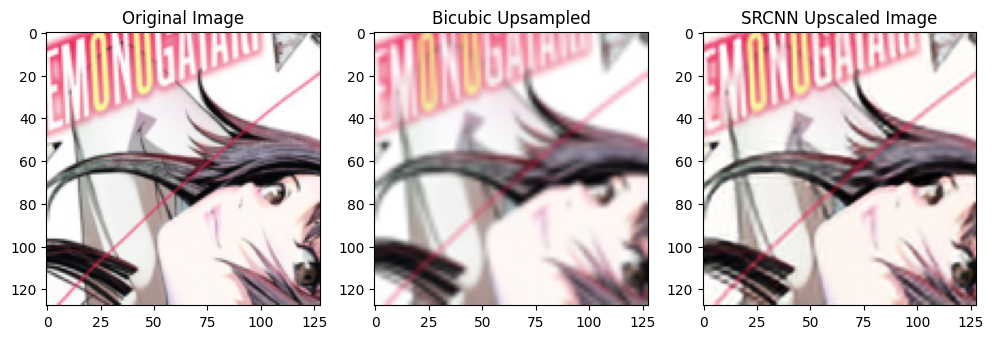

In [ ]:
# pull i from dataset and model(i) to get output
iterations = 3

for i in range(iterations):
  lr_img, target, img_path = dataset[randint(0, len(dataset) - 1)]

  # have to convert lr_img from 3D to 4D, then convert from 4D back to 3D
  output = model(lr_img).squeeze(0)

  # convert the image tensors to np array to be displayed
  lr_image_np = lr_img.permute(1, 2, 0).numpy()
  target_np = target.permute(1, 2, 0).numpy()
  output_np = output.permute(1, 2, 0).detach().numpy().clip(0, 1)

  # display images
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(target_np)
  plt.title('Original Image')

  plt.subplot(1, 3, 2)
  plt.imshow(lr_image_np)
  plt.title('Bicubic Upsampled')

  plt.subplot(1, 3, 3)
  plt.imshow(output_np)
  plt.title('SRCNN Upscaled Image')

  plt.show()

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# SHOULD CONVERT TO DICTIONARY AND REMOVE REDUNDANT/BAD CODE
iterations = int(len(dataset) * 0.2)
mean_ssim_model = 0
mean_psnr_model = 0
mean_mse_model = 0

mean_ssim_bicubic = 0
mean_psnr_bicubic = 0
mean_mse_bicubic = 0

for i in range(iterations):
    lr_img, target, img_path = dataset[randint(0, len(dataset) - 1)]

    lr_img_4d = lr_img.unsqueeze(0)
    output = model(lr_img_4d).squeeze(0)

    # convert to numpy array
    output_np = output.permute(1, 2, 0).detach().numpy()
    target_np = target.permute(1, 2, 0).numpy()
    lr_image_np = lr_img.permute(1, 2, 0).numpy()

    # calc SSIM model
    ssim_val_model, _ = ssim(target_np, output_np, full=True, multichannel=True)
    mean_ssim_model += ssim_val_model

    # calc SSIM bicubic
    ssim_val_bicubic, _ = ssim(target_np, lr_image_np, full=True, multichannel=True)
    mean_ssim_bicubic += ssim_val_bicubic

    # calc MSE model
    mse_val_model = mse(target_np, output_np)
    mean_mse_model += mse_val_model

    # calc MSE bicubic
    mse_val_bicubic = mse(target_np, lr_image_np)
    mean_mse_bicubic += mse_val_bicubic

    # calc PSNR model
    psnr_val_model = psnr(target_np, output_np)
    mean_psnr_model += psnr_val_model

    # calc PSNR bicubic
    psnr_val_bicubic = psnr(target_np, lr_image_np)
    mean_psnr_bicubic += psnr_val_bicubic

# model
mean_ssim_model /= iterations
mean_psnr_model /= iterations
mean_mse_model /= iterations

# bicubic
mean_ssim_bicubic /= iterations
mean_psnr_bicubic /= iterations
mean_mse_bicubic /= iterations

print("Mean SSIM_model:", mean_ssim_model)
print("Mean PSNR_model:", mean_psnr_model)
print("Mean MSE_model:", mean_mse_model)
print()

print("Mean SSIM_bicubic:", mean_ssim_bicubic)
print("Mean PSNR_bicubic:", mean_psnr_bicubic)
print("Mean MSE_bicubic:", mean_mse_bicubic)


Mean SSIM_model: 0.895790453854046
Mean PSNR_model: 24.805725571092193
Mean MSE_model: 0.003701279038800253

Mean SSIM_bicubic: 0.87219396689264
Mean PSNR_bicubic: 23.89577950715393
Mean MSE_bicubic: 0.004571836155188698


In [ ]:
# load file path, for next code block
lr_img, target, input_image_path = dataset[12]

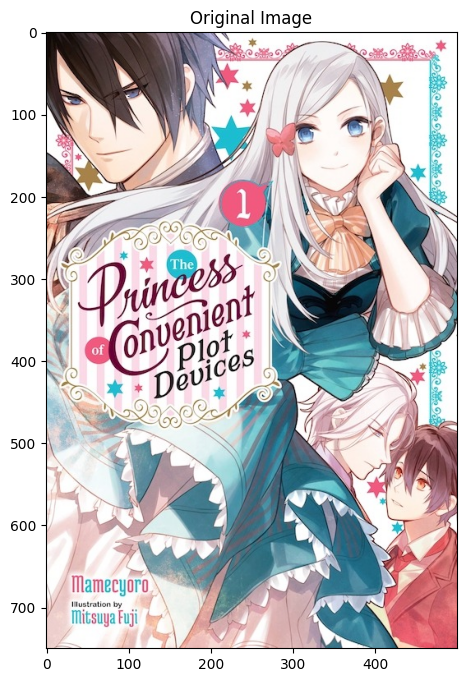

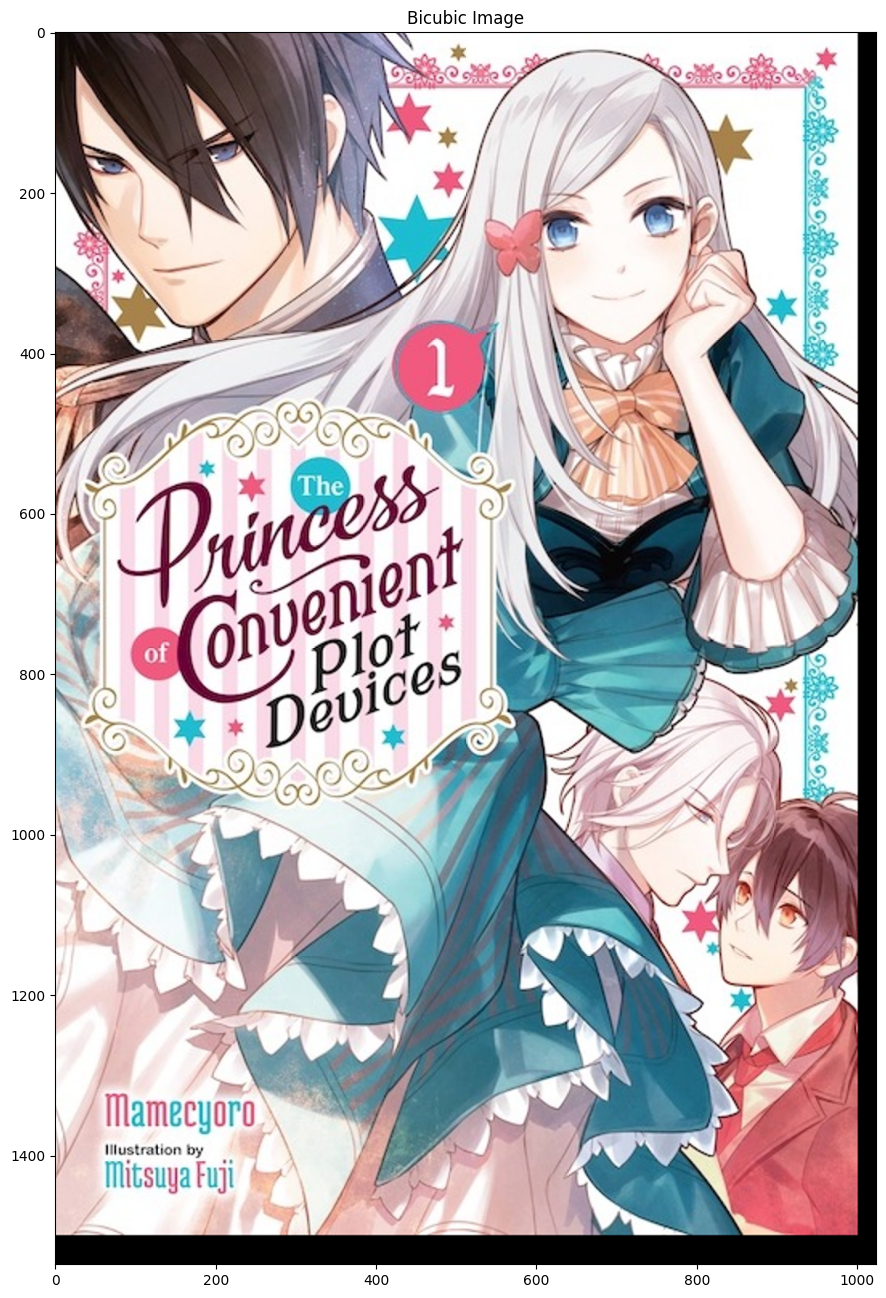

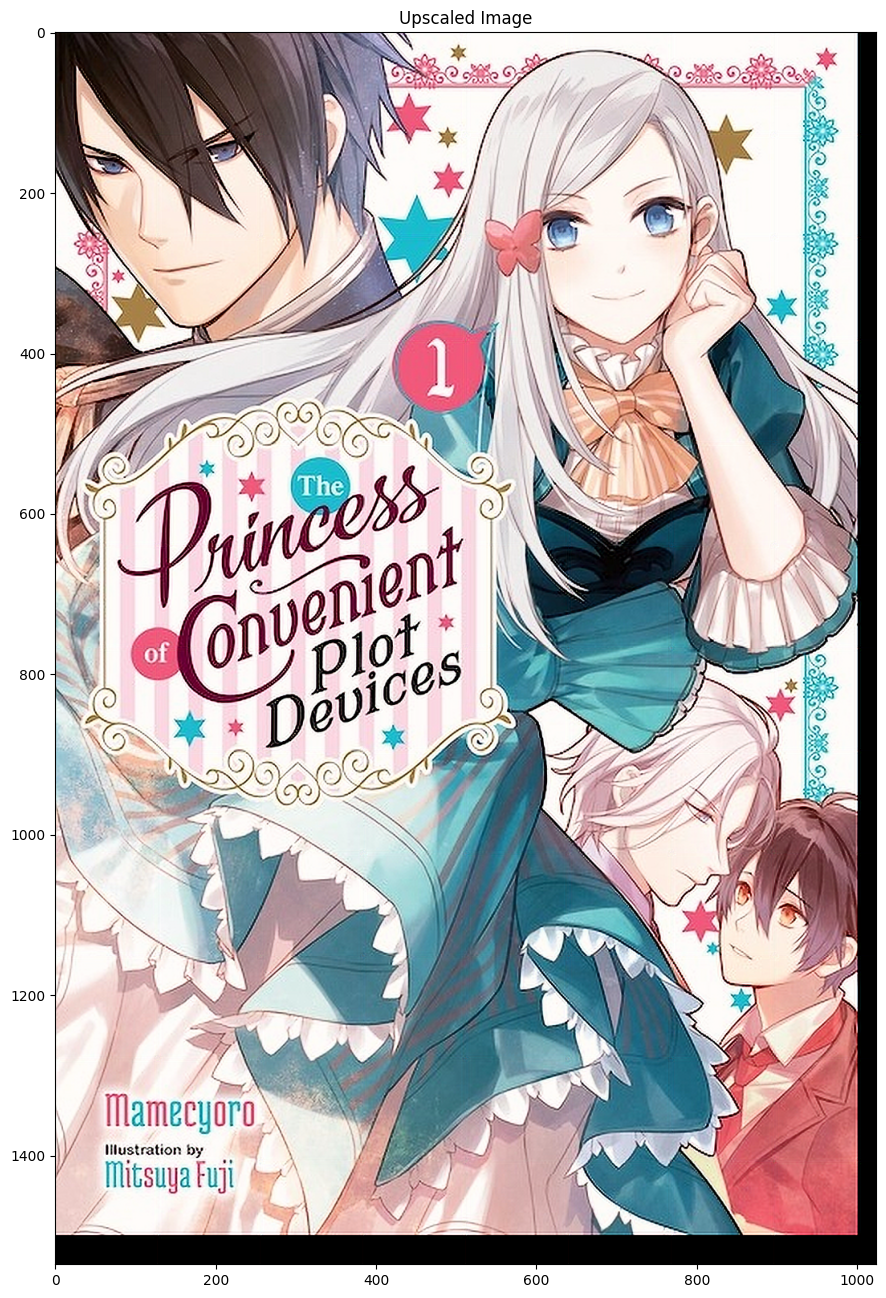

In [ ]:
# load the input image
input_image = Image.open(input_image_path).convert('RGB')

# define transform to covnert image to tensor
input_transform = transforms.Compose([
    transforms.ToTensor(),
])

# split the image into 64x64 sections
def split_image(image, chunk_size=64):
    columns = 0
    width, height = image.size
    chunks = []
    for y in range(0, height, chunk_size):
        for x in range(0, width, chunk_size):
            box = (x, y, x + chunk_size, y + chunk_size)
            chunk = image.crop(box)
            chunks.append(chunk)
            if y == 0:
                columns += 1
    return chunks, columns

# upscale each chunk 2x with bicubic interpolation
def upscale_chunk(chunk):
    width, height = chunk.size
    upscaled_chunk = chunk.resize((width * 2, height * 2), resample=Image.BICUBIC)
    return upscaled_chunk

# convert each upscaled chunk to tensor
def chunk_to_tensor(chunk):
    return input_transform(chunk).unsqueeze(0)

# reconstruct chunks back into one image
def reconstruct_image(chunks, num_columns):
    num_chunks = len(chunks)
    num_rows = num_chunks // num_columns
    final_image = np.zeros((num_rows * 128, num_columns * 128, 3), dtype=np.float32)

    for i, chunk in enumerate(chunks):
        row = i // num_columns
        col = i % num_columns
        final_image[row*128:(row+1)*128, col*128:(col+1)*128, :] = chunk
    return final_image

# split image into chunks
image_chunks, cols = split_image(input_image)

# upscale each chunk, convert to tensor, pass through model
upscaled_chunks = []
bi_cubic_chunks = []
for chunk in image_chunks:
    upscaled_chunk = upscale_chunk(chunk)
    chunk_tensor = chunk_to_tensor(upscaled_chunk)
    bi_cubic_chunks.append(chunk_tensor.squeeze(0))

    with torch.no_grad():
        output_chunk = model(chunk_tensor)
    upscaled_chunks.append(output_chunk.squeeze(0))

# manipulate chunks so they are in correct format
chunks = [chunk.permute(1, 2, 0).detach().numpy().clip(0, 1) for chunk in upscaled_chunks]
bi_cubic_chunks = [chunk.permute(1, 2, 0).detach().numpy().clip(0, 1) for chunk in bi_cubic_chunks]

# reconstruct bicuibc upscaling and model upscaled image
full_image= reconstruct_image(chunks, cols)
bicubic_image = reconstruct_image(bi_cubic_chunks, cols)
original_image = Image.open(input_image_path).convert('RGB')

# display the original image
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title('Original Image')
plt.show()

# display the bicubic image
plt.figure(figsize=(16, 16))
plt.imshow(bicubic_image)
plt.title('Bicubic Image')
plt.show()

# display the model image
plt.figure(figsize=(16, 16))
plt.imshow(full_image)
plt.title('Upscaled Image')
plt.show()

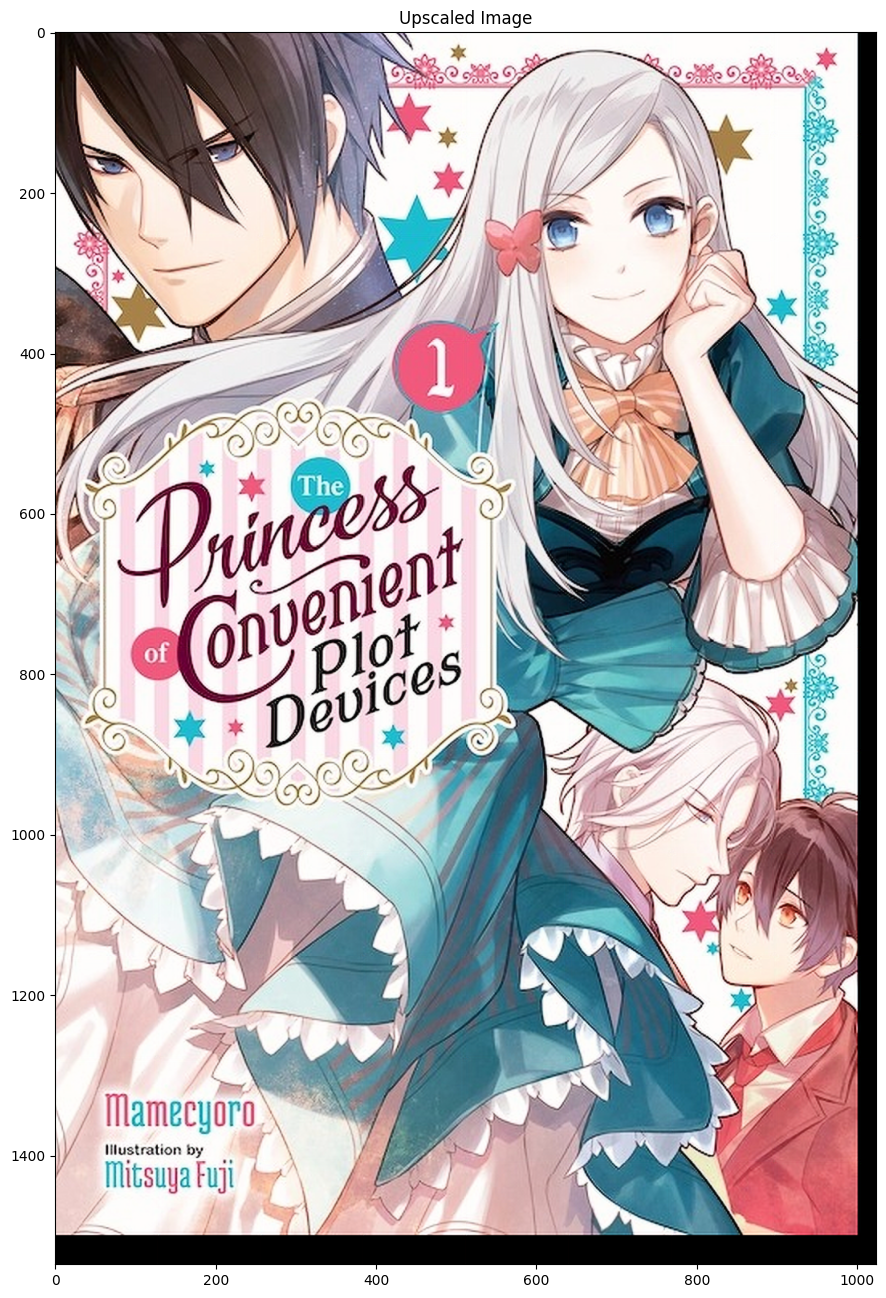

In [ ]:
alpha = 0.5  # 0 for model, 1 for bicubic
interpolated_image = (1 - alpha) * full_image + alpha * bicubic_image

plt.figure(figsize=(16, 16))
plt.imshow(interpolated_image)
plt.title('Upscaled Image')
plt.show()


In [ ]:
import shutil
shutil.make_archive('models', 'zip', '/content/models')

'/content/models.zip'

In [ ]:
from google.colab import files
files.download('models.zip')